In [12]:
%matplotlib inline
import os
import pandas as pd
import numpy as np

import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import matplotlib.ticker as mticker

import seaborn as sns
import scienceplots
from itertools import accumulate

import torch

In [19]:
def plot_res(save_folder, num_runs, tasks, legends, lr_list, file_name=None, K=None, init_points=None):
    def stack_runs(task, key, lr):
        curves = []
        for r in num_runs:
            if task in ("diffusion_distr_est", "diffusion_point_est", "diffusion_distr_est_resample", "diffusion_distr_est_old"):
                fpath = os.path.join(save_folder, f"{r}_{lr}", f"{task}")
            else:
                fpath = os.path.join(save_folder, f"{r}", f"{task}")
            res = torch.load(fpath, weights_only=True)
            values = np.asarray(res[key], dtype=float)
            if key == "total_training_time_list" and "diffusion" in task:
                values = np.fromiter(accumulate(values), dtype=float)
            if K is not None:
                values = values[:K]
            if values.shape[0] == 50:
                curves.append(values)
        return np.stack(curves)

    plt.style.use(["science", "no-latex"])
    sns.set_theme(style="whitegrid", context="paper")
    # plt.rcParams.update({
    #     "axes.labelsize": 8,
    #     "xtick.labelsize": 7,
    #     "ytick.labelsize": 7,
    #     "axes.linewidth": .6,
    #     "legend.fontsize": 8,
    # })
    plt.rcParams.update({
        "font.size": 8, "axes.labelsize": 9, "legend.fontsize": 8,
        "xtick.labelsize": 8, "ytick.labelsize": 8, "axes.linewidth": .6,
        "pdf.fonttype": 42, "ps.fonttype": 42
    })

    metrics = [
        ("train_dfl_losses", "Train DFL loss"),
        ("test_dfl_losses",  "Test DFL loss"),
        # ("total_training_time_list", "Cumulative training time (s)")
    ]

    ls_pool = ["-", "--", "-.", ":", (0, (1, 1)), (0, (3, 1, 1, 1)),
               (0, (5, 1)), (0, (5, 2, 1, 2)), (0, (2, 2)), (0, (3, 5, 1, 5))]

    num_sub_fig = len(metrics)
    # fig, axes = plt.subplots(1, num_sub_fig, figsize=(7.0, 1.8), dpi=220, sharey=False)
    fig = plt.figure(figsize=(7.0, 1.8), dpi=220)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.45)
    axes_1 = fig.add_subplot(gs[0, 0])
    axes_2 = fig.add_subplot(gs[0, 1])
    axes = [axes_1, axes_2]
    LEG_Y = 1.2 

    if num_sub_fig == 1:
        axes = [axes]

    handles_all, labels_all = [], []

    for idx, (key, y_label) in enumerate(metrics):
        ax = axes[idx]
        for i, task in enumerate(tasks):
            data = stack_runs(task, key, lr_list[i])  # (R, E)

            if init_points is not None and key in init_points:
                init_val = float(init_points[key])
                init_col = np.full((data.shape[0], 1), init_val, dtype=float)
                data = np.concatenate([init_col, data], axis=1)

            epochs = np.arange(data.shape[1])
            mean, std = data.mean(0), data.std(0)

            h, = ax.plot(epochs, mean, linestyle=ls_pool[i], linewidth=1.0, label=legends[i])
            ax.fill_between(epochs, mean-std, mean+std, alpha=.2)

            if idx == 0:
                handles_all.append(h)
                labels_all.append(legends[i])

        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_label)
        ax.set_xlim(0, 50)
        ax.set_yscale("log", base=2)
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.grid(True, axis="y", linewidth=.3, alpha=.6)
        plt.ticklabel_format(axis='y', style='plain')

        ax.set_title("(b) Test loss for importance sampling (IS)", pad=20)

        ax.legend(handles_all, labels_all, loc="upper center",
              bbox_to_anchor=(0.5, LEG_Y), ncol=len(handles_all),
              frameon=False, handlelength=2, columnspacing=1.0, fontsize=8)

    # n_items = len(handles_all)
    # fig.legend(handles_all, labels_all, loc="lower center",
    #            bbox_to_anchor=(0.5, -0.12), ncol=n_items,
    #            frameon=False, handlelength=2, columnspacing=1.0, fontsize=10)

    # fig.tight_layout(pad=.6, rect=[0.03, 0.16, 1, 0.88])
    plt.savefig(f"{file_name}.pdf", bbox_inches="tight", format="pdf", dpi=300)

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    to_inches = fig.dpi_scale_trans.inverted()
    bbox_a = axes_1.get_tightbbox(renderer).transformed(to_inches).expanded(1.02, 1.08)
    bbox_b = axes_2.get_tightbbox(renderer).transformed(to_inches).expanded(1.02, 1.08)

    fig.savefig(f"{file_name}_panel_a.pdf", bbox_inches=bbox_a, dpi=1000)
    fig.savefig(f"{file_name}_panel_b.pdf", bbox_inches=bbox_b, dpi=1000)
    plt.show()

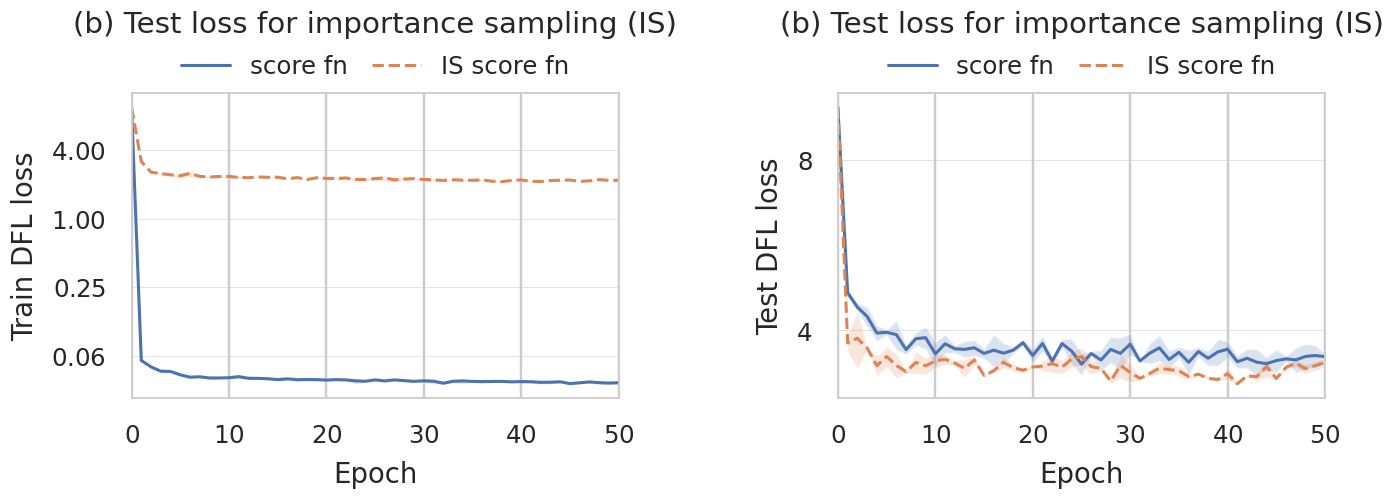

In [ ]:
Init_train_DFL = 9.5345
Init_hold_DFL = 11.3900
Init_test_DFL = 9.8865
init_points = {
    "train_dfl_losses": Init_train_DFL,
    "val_dfl_losses":   Init_hold_DFL,
    "test_dfl_losses":  Init_test_DFL,
}

tasks = ["diffusion_distr_est_old", "diffusion_distr_est"]
legends = ["score fn", "IS score fn"]
lr_list = ["8e-06", "8e-06"]

YOUR_HOME_FOLDER = ""
YOUR_SAVE_FOLDER_NAME = "" 
save_folder = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", YOUR_SAVE_FOLDER_NAME)
runs = [2, 3, 4]

plot_res(save_folder, runs, tasks, legends, lr_list, file_name="compare_resample_method", init_points=init_points)